<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 30% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

**DONE:**

* Watch tutorial


In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
ds = datasets.FashionMNIST('/tmp/fashionmnist', train = True,
                                           transform=transforms.ToTensor(),
                                           download=True)

In [0]:
class FashionMNISTDataset(Dataset):
    def __init__(self, root, train=True):
      self.data = datasets.FashionMNIST(root,
                                     train=train,
                                     transform=transforms.ToTensor(),
                                     download=True)
    
    def __getitem__(self,i):
      x,y = self.data[i]      
      return x,y
    
    def __len__(self):
      return len(self.data) 

    

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

**DONE:**
* Conv2D
* CrossEntropyLoss 



___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform



In [0]:
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, ignore_index=-100,
                 reduce=None, reduction='mean'):
        super(CrossEntropyLoss, self).__init__()
    
    def forward(self,guess,real):
      '''
      parameters:
      y_hat (tensor): tensor of batch_size by num_classes
      y_truth (tensor): batch_size x 1 Tensor, with entries in the range [0, 9]
      
      returns:
      loss (float): the cross entropy loss between y_hat and y_truth
      '''
      b, c  = guess.size() # batch_size, num_classes
      
      # -- First find the real class component ---
      
      # real_mask is a matrix of one hot vectors of the answers
      real_mask = torch.eye(c)[real] # max(n) takes max on the nth axis.  It returns an array of values
                                     # at position [0], and indicies (which I use here) at position [1].
        
      # actual_class_component is a vector containing the values given to the correct class
      actual_class_component = torch.sum(real_mask.cuda()*guess, dim = 1) # summing simply gets rid of the zeros

      # -- next find the component given by the other classes ---
      
      exp_guesses = torch.exp(guess) # exponentiates the predicted values
      # zeros out the number for 'real answer' class
#       exp_guesses[real_mask.cuda()==1] = 0.cuda()  # this should be in place, but it breaks the code if I put it in...
#       exp_guesses = exp_guesses.cuda()             # this should be in place, but it breaks the code if I put it in...
      
      other_class_component = torch.log(torch.sum(exp_guesses,dim=1)) # sums along dimension 1, 
                                                                           # then takes the log of each remaining element
      loss = other_class_component - actual_class_component # the loss is defined as this check out cross 
                                                            # entropy loss at https://pytorch.org/docs/stable/nn.html
      
      return torch.mean(loss) # we want to return the average loss over the batch
      
      



class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, init_strategy='xav', 
                 stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
        self.__dict__.update(locals()) # takes all the paramaters as input 
        super(Conv2d,self).__init__()


        self.weight = Parameter(torch.Tensor(
                                 out_channels, 
                                 in_channels, 
                                 *kernel_size))  # the *kernel_size unpacks kernel[0] and kernel[1] into two variables
        self.bias = Parameter(torch.Tensor(out_channels))
        
        self.bias.data.uniform_(0,0) # initialize the bias as all zeros
        
        # select which of the three initialization strategies to use (Xav, orth, or uniform)
        if init_strategy == 'xav':
          # xavier initialization
            torch.nn.init.xavier_uniform_(self.weight)
            
        elif init_strategy == 'orth':
          # orthogonal initialization
            M = np.random.random((out_channels, in_channels * kernel_size[0] * kernel_size[1])).astype(np.float32)
            U, _, Vt = np.linalg.svd(M, full_matrices=False)
                # if the matrix M has more rows than columns, use U as the orthonormal matrix
                # rather than V.  See https://en.wikipedia.org/wiki/Singular_value_decomposition
                # for visualization
            if len(M) > len(M[0]):    # if there are more rows than columns
                W = U.reshape((out_channels, in_channels, kernel_size[0], kernel_size[1]))
            else:
                W = Vt.reshape((out_channels, in_channels, kernel_size[0], kernel_size[1]))
            self.weight.data = torch.from_numpy(W) # sets the weights created 
                                                   # in numpy to the weight matrix    
        elif init_strategy == 'uniform':
            self.weight.data.uniform_(-1,1)
        else:
          raise ValueError("init_strategy needs to be 'xav', 'orth', or 'uniform'")
            
        
    def forward(self, x):
      return F.conv2d(x, self.weight, self.bias, self.stride,
                      self.padding, self.dilation, self.groups)
    
    def extra_repr(self): # allows us to configure the string that this custom class
                          # prints out
      pass

In [0]:
class ConvNetwork(nn.Module):
  def __init__(self,dataset):
    super(ConvNetwork,self).__init__()
    x,y = dataset[0]
    c, h, w = x.size()
    output = 10
    
    self.net = nn.Sequential(
        Conv2d(c, 10, (3,3), init_strategy = 'xav', padding=(1,1)),
        nn.ReLU(),
        Conv2d(10, 10, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(10, 10, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(10, output, (28,28), padding=(0,0)),   
    )
    
  def forward(self,x):
      # returns the network's best guess for the y associated with x:
      # (n, 10, 1, 1)
      # (n, 10, 1)
      # (n, 10)
      return self.net(x).squeeze(-1).squeeze(-1)   


In [0]:
# Initialize Datasets
train_dataset = FashionMNISTDataset('/tmp/fashionmnist')
check_dataset = FashionMNISTDataset('/tmp/fashionmnist',train=False)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset,
                         batch_size=50,
                         pin_memory=True)
check_loader = DataLoader(train_dataset,
                         batch_size=50,
                         pin_memory=True)

# Initialize Model
model = ConvNetwork(train_dataset)
model = model.cuda()

# Initialize Objective funcitionand Optimizer and other parameters
lossfn = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

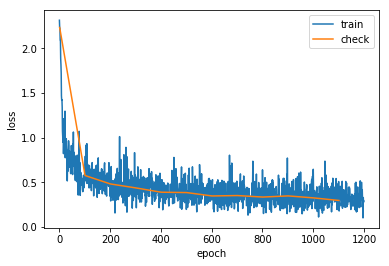

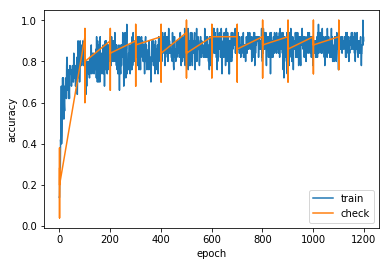

In [54]:
losses = []
checks = []
tr_acc = []
ch_acc = []

# Run your training and validation loop and collect stats
for epoch in range(1):

    loop = tqdm(total = len(train_loader), position=0, leave=False)

    for batch, (x,y_truth) in enumerate(train_loader):
      x,y_truth = x.cuda(async=True), y_truth.cuda(async=True)

      optimizer.zero_grad()
      
      y_hat = model(x)
      loss = lossfn(y_hat, y_truth)

      loss.backward()

      losses.append(loss.item())
      tr_acc.append((torch.softmax(y_hat,1).argmax(1) == y_truth).float().mean())
      accuracy = 0
      loop.set_description('epoch:{} , loss:{:4f}, accuracy:{:4f}'.format(epoch,
                                                                  loss,accuracy))
      loop.update(1)

      optimizer.step()

      if batch % 100 ==0:
        check = np.mean([lossfn(model(x.cuda()), y.cuda()).item() for x,y in check_loader])
        checks.append((len(losses), check)) # len(losses) gives the x term, check
                                            # gives the y term for easy graphing
        for x,y in check_loader:
          y_hat = model(x.cuda())
          y = y.cuda()
          ch_accuracy = (torch.softmax(y_hat,1).argmax(1) == y).float().mean()  
          ch_acc.append( (len(losses),ch_accuracy) )  

    loop.close()

a,b = zip(*checks)
plt.plot(losses, label = "train")
plt.plot(a,b, label = "check")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

c,d = zip(*ch_acc)
plt.plot(tr_acc, label = "train")
plt.plot(c,d, label = "check")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()



___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

**TODO:**
 

**DONE:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model


In [0]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy



In [55]:
# Compute and print the number of parameters in the model
def parameter_count(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  return sum([np.prod(p.size()) for p in model_parameters])

parameter_count(model)

80330

___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out = 22, k = (3,3), p = (1,1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out = 65, k = (3,3), p = (2,2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out = 7, k = (3,3), p = (6,6))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out = 100, k = (5,5), p = (2,2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out = 23, k = (5,5), p = (3,3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out = 5, k = (5,5), p = (9,9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out = 10, k = (5,3), p = (1,0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out = 100, k = (5,3), p = (2,1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out = 23, k = (5,3), p = (3,2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out = 5, k = (5,3), p = (9,8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **(out = 10, k = (2,4), p = (0,0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out = 22, k = (1,1), p = (0,0))**

**TODO:**

**DONE:**
* Answer all the questions above 


In [44]:
# Write some test code for checking the answers for these problems (example shown in the video)

# c=3,h=10,w=10 -> c=10,h=8,w=8) : out=10, ksize=3,3, padding=0,0
c = nn.Conv2d(3,10,kernel_size=(1,1), padding=(0,0))
c(torch.zeros(1,3,10,10)).size()

torch.Size([1, 10, 10, 10])